In [1]:
#Importing essential libraries

import numpy as np
import os
import imageio
import cv2
import datetime

import warnings
warnings.filterwarnings("ignore")

from imageio import imread

np.random.seed(30)
import random as rn
rn.seed(30)

from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [2]:
# Declaring path to parent directory
Source = "G:\\My Drive\\Project_data"

In [3]:
#Setting Image dimensions
height, width = 90, 90

In [5]:
# Code stub to do the preprocessing on the Images and convert them into 4D Tensors. This is to avoid dependency on preprocessing while the training process,
# so as to fully make use of gpu and speed up the training process. Please run this for both training and validation sets

from tqdm import tqdm  # progress bar

# Define paths
#To access the data

input_root = Source + '\\train' # Change this path to validation data while creating tensors for val set
output_root = Source + '\\train_converted' 
img_idx = [3, 7, 9, 10, 11, 13, 17, 21, 24, 26, 28, 29]  # Or your custom indices to select from 30 frames
target_size = (height, width)     # set height and width as defined
crop_margin = 20           # Pixels to crop from all sides

# Ensure output root exists
os.makedirs(output_root, exist_ok=True)

# Iterate over each folder
for folder_name in tqdm(os.listdir(input_root), desc="Processing Folders"):
    input_folder_path = os.path.join(input_root, folder_name)
    output_folder_path = os.path.join(output_root, folder_name)

    if not os.path.isdir(input_folder_path):
        continue

    os.makedirs(output_folder_path, exist_ok=True)

    image_files = sorted(os.listdir(input_folder_path))
    selected_images = []

    for idx in img_idx:
        if idx < len(image_files):
            img_path = os.path.join(input_folder_path, image_files[idx])
            img = cv2.imread(img_path)

            if img is not None:
                # Crop from all sides
                h, w, _ = img.shape
                cropped = img[crop_margin:h - crop_margin, crop_margin:w - crop_margin]

                # Resize to target size
                resized = cv2.resize(cropped, target_size, interpolation=cv2.INTER_AREA)

                # Normalize and store
                norm_img = resized.astype(np.float32) / 255.0
                selected_images.append(norm_img)

    # Save if correct number of frames found
    if len(selected_images) == len(img_idx):
        npy_array = np.array(selected_images)  # shape: (12, 80, 80, 3)
        np.save(os.path.join(output_folder_path, 'sequence.npy'), npy_array)
    else:
        print(f"Skipped {folder_name} due to missing or unreadable frames.")


Processing Folders: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 663/663 [08:33<00:00,  1.29it/s]


In [6]:
# Create augmentations, only applicable for training set

import random
import shutil

# Paths
input_root = Source + '\\train_converted'  # contains original 663 sequences
output_root = Source + '\\train_augmented_random'
os.makedirs(output_root, exist_ok=True)

# Count original folders
all_folders = [f for f in os.listdir(input_root) if os.path.isdir(os.path.join(input_root, f))]
assert len(all_folders) == 663, "Expected 663 original training folders"

# Randomly pick 337 folders without repetition
aug_folders = random.sample(all_folders, 337)

# === Augmentation Functions ===
def random_brightness(frame):
    factor = 0.6 + np.random.uniform() * 0.8
    return np.clip(frame * factor, 0, 1)

def random_flip(frame):
    return cv2.flip(frame, 1)

def random_rotation(frame):
    angle = random.uniform(-15, 15)
    center = (frame.shape[1] // 2, frame.shape[0] // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(frame, matrix, (frame.shape[1], frame.shape[0]))

def augment_sequence(sequence):
    augmented = []
    for frame in sequence:
        if random.random() < 0.5:
            frame = random_flip(frame)
        if random.random() < 0.5:
            frame = random_rotation(frame)
        if random.random() < 0.5:
            frame = random_brightness(frame)
        augmented.append(frame)
    return np.array(augmented, dtype=np.float32)

# === Copy Originals ===
print("Copying 663 original sequences...")
for folder_name in tqdm(all_folders, desc="Copying originals"):
    src_path = os.path.join(input_root, folder_name, 'sequence.npy')
    dest_folder = os.path.join(output_root, folder_name)
    os.makedirs(dest_folder, exist_ok=True)
    dest_path = os.path.join(dest_folder, 'sequence.npy')
    shutil.copyfile(src_path, dest_path)

# === Create 337 augmentations ===
print("Creating 337 augmentations...")
for folder_name in tqdm(aug_folders, desc="Augmenting"):
    src_seq_path = os.path.join(input_root, folder_name, 'sequence.npy')
    if not os.path.exists(src_seq_path):
        continue

    sequence = np.load(src_seq_path)
    aug_sequence = augment_sequence(sequence)

    # Save with a new folder name to avoid overwrite
    new_folder_name = folder_name + "_aug"
    dest_folder = os.path.join(output_root, new_folder_name)
    os.makedirs(dest_folder, exist_ok=True)
    np.save(os.path.join(dest_folder, 'sequence.npy'), aug_sequence)

print("\n✅ Final training data size: 663 originals + 337 augmentations = 1000 sequences.")
print(f"📁 All saved in: {output_root}")


Copying 663 original sequences...


Copying originals: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 663/663 [03:34<00:00,  3.09it/s]


Creating 337 augmentations...


Augmenting: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 337/337 [01:57<00:00,  2.88it/s]


✅ Final training data size: 663 originals + 337 augmentations = 1000 sequences.
📁 All saved in: G:\My Drive\Project_data\train_augmented_random


In [7]:
import os

# Paths
converted_root = Source + '\\train_augmented_random'  # Folder with 1000 folders (original + aug)
original_csv = os.path.join(Source, 'train.csv')      # Original CSV
output_csv = os.path.join(Source, 'train+augmented.csv')  # Final output

# Step 1: Read original labels into a dict
label_dict = {}
with open(original_csv, 'r') as f:
    for line in f:
        parts = line.strip().split(';')
        if len(parts) == 3:
            folder_name, gesture_name, label = parts
            label_dict[folder_name] = (gesture_name, label)

# Step 2: Create lines for new CSV
output_lines = []

for folder_name in os.listdir(converted_root):
    if not os.path.isdir(os.path.join(converted_root, folder_name)):
        continue

    # Determine base name
    base_name = folder_name[:-4] if folder_name.endswith('_aug') else folder_name

    if base_name in label_dict:
        gesture_name, label = label_dict[base_name]
        entry = f"{folder_name};{gesture_name};{label}"
        output_lines.append(entry)

# Step 3: Write to final CSV (no header)
with open(output_csv, 'w') as f:
    for line in output_lines:
        f.write(line + '\n')

print(f"✅ One-column CSV written at: {output_csv}")
print(f"🧾 Total entries: {len(output_lines)} (Original: 663, Augmented: {len(output_lines) - 663})")


✅ One-column CSV written at: G:\My Drive\Project_data\train+augmented.csv
🧾 Total entries: 1000 (Original: 663, Augmented: 337)


In [8]:
video_len = len(img_idx)

In [9]:
# Defining Generator code to feed the model with preprocessed data during training. 

def generator(source_path, folder_list, batch_size):
    print('Source path =', source_path, '; batch size =', batch_size)

    while True:
        np.random.shuffle(folder_list)

        num_batches = len(folder_list) // batch_size # Number of batches

        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, video_len, height, width, 3)) #Placeholder tensor for batch data
            batch_labels = np.zeros((batch_size, 5)) # Placeholder for one-hot encoded batch labels

            for folder in range(batch_size):
                # Parse folder name and label
                entry = folder_list[folder + batch * batch_size] # getting the particular instance of particular batch
                folder_name = entry.split(';')[0] # For parsing folder name
                label = int(entry.strip().split(';')[2]) # For parsing gesture label

                # Load preprocessed .npy file
                npy_path = os.path.join(source_path, folder_name, 'sequence.npy') # Path to 4d tensor stored in different folder during preprocessing

                if not os.path.exists(npy_path):
                    print(f"Missing file: {npy_path}")
                    continue

                sequence = np.load(npy_path)

                if sequence.shape != (video_len, height, width, 3):
                    print(f"Shape mismatch in: {npy_path}")
                    continue

                batch_data[folder] = sequence
                batch_labels[folder, label] = 1

            yield batch_data, batch_labels

        # Handle remaining data if not divisible by batch size
        remaining_samples = len(folder_list) % batch_size
        if remaining_samples > 0:
            batch_data = np.zeros((remaining_samples, video_len, height, width, 3))
            batch_labels = np.zeros((remaining_samples, 5))

            for folder in range(remaining_samples):
                entry = folder_list[num_batches * batch_size + folder]
                folder_name = entry.split(';')[0]
                label = int(entry.strip().split(';')[2])

                npy_path = os.path.join(source_path, folder_name, 'sequence.npy')

                if not os.path.exists(npy_path):
                    print(f"Missing file: {npy_path}")
                    continue

                sequence = np.load(npy_path)

                if sequence.shape != (video_len, height, width, 3):
                    print(f"Shape mismatch in: {npy_path}")
                    continue

                batch_data[folder] = sequence
                batch_labels[folder, label] = 1

            yield batch_data, batch_labels


In [10]:
train_doc = np.random.permutation(open(Source + "\\train+augmented.csv", "r").read().splitlines()) # Setting path to train.csv
val_doc = np.random.permutation(open(Source + "\\val.csv", "r").read().splitlines()) # Setting path to val.csv

In [11]:
# Libraries for Model Building (3D CNN Arhictecture)
from keras.models import Sequential
from keras.layers import BatchNormalization, Flatten, Dropout, Dense
from keras import optimizers

In [12]:
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D

In [13]:
# Building Model
model = Sequential()

# Block 1
model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=(video_len, height, width, 3)))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))  # Temporal dimension preserved

# Block 2
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))  # Temporal downsample

# Block 3
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Block 4 (optional but adds power)
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Global Feature Compression
model.add(GlobalAveragePooling3D())

# Fully Connected Layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(5, activation='softmax'))  # 5 gesture classes


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy']) # Compiling model for fast reference
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 12, 90, 90, 16)    1312      
                                                                 
 batch_normalization (BatchN  (None, 12, 90, 90, 16)   64        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 12, 45, 45, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 45, 45, 32)    13856     
                                                                 
 batch_normalization_1 (Batc  (None, 12, 45, 45, 32)   128       
 hNormalization)                                                 
                                                        

In [14]:
import numpy as np
import datetime
# Load and shuffle CSV data correctly (fixing backslashes and removing extra newlines)

train_doc = np.random.permutation(open(Source + "\\train+augmented.csv", "r").read().splitlines())
val_doc = np.random.permutation(open(Source + "\\val.csv", "r").read().splitlines())


curr_dt_time = datetime.datetime.now()

train_path = Source + "\\train_augmented_random"
val_path = Source + "\\val_converted"
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 100
print ('# epochs =', num_epochs)
batch_size = 4

# training sequences = 1000
# validation sequences = 100
# epochs = 100


In [15]:
#  create the train_generator and the val_generator which will be used in .fit_generator.
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

# Creating a Folder for Saving the Model, Model Checkpoints, Reduce Learning Rate When Training Slows Down, Callbacks
import os
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# Get current time for unique model naming
curr_dt_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_name = 'model_init_' + curr_dt_time.replace(' ', '').replace(':', '_') + '/'
# Ensure the directory exists
os.makedirs(model_name, exist_ok=True)
# Define file path for saving model checkpoints
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'
# ModelCheckpoint - Save all epochs
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
# ReduceLROnPlateau - Reduce LR when val_loss stops improving
LR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, verbose = 1)
# Callback list
callbacks_list = [checkpoint, LR]

#  ensuring all videos are included in training and validation
import math

steps_per_epoch = math.ceil(num_train_sequences / batch_size)
validation_steps = math.ceil(num_val_sequences / batch_size)

In [16]:
import time
start_time = time.time()

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps,class_weight=None, initial_epoch=0)

end_time = time.time()
print(f"Total training time: {round((end_time - start_time) / 60, 2)} minutes")

Source path = G:\My Drive\Project_data\train_augmented_random ; batch size = 4
Epoch 1/100
250/250 [==============================] - ETA: 0s - loss: 1.5517 - categorical_accuracy: 0.3520Source path = G:\My Drive\Project_data\val_converted ; batch size = 4

Epoch 1: val_loss improved from inf to 1.68560, saving model to model_init_2025-06-28_22-54-02\model-00001-1.55168-0.35200-1.68560-0.27000.keras
250/250 [==============================] - 69s 199ms/step - loss: 1.5517 - categorical_accuracy: 0.3520 - val_loss: 1.6856 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/100
250/250 [==============================] - ETA: 0s - loss: 1.3685 - categorical_accuracy: 0.4250
Epoch 2: val_loss did not improve from 1.68560
250/250 [==============================] - 47s 190ms/step - loss: 1.3685 - categorical_accuracy: 0.4250 - val_loss: 2.2658 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/100
250/250 [==============================] - ETA: 0s - loss: 1.2579 - categorical_accurac

In [17]:
import matplotlib.pyplot as plt

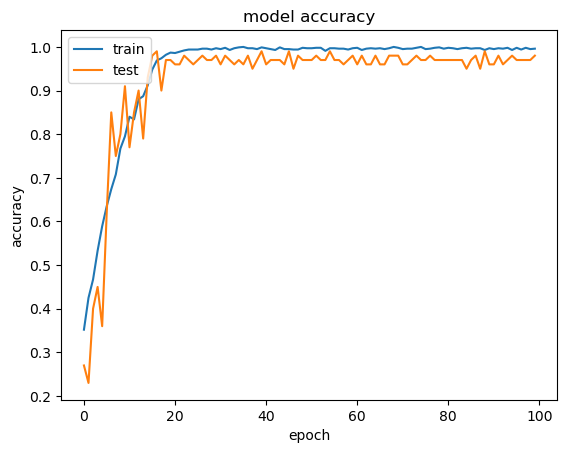

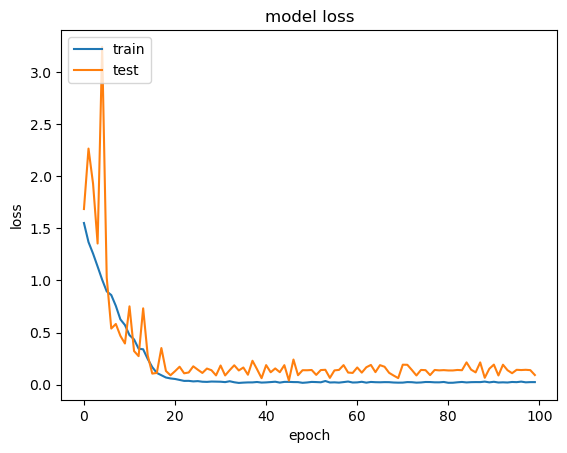

In [18]:
# Plotting the result of Model 6:

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Based on training logs, the best of the models seem to be at Epoch 46 with the following metrics:

**Epoch 46**

- Training Accuracy: 99.50%
- Validation Accuracy: 99.00%
- Training Loss: 0.0271
- Validation Loss: 0.0396

In [19]:
#For loading the model
from tensorflow.keras.models import load_model

In [20]:
# Path to saved model
model_path = "model_init_2025-06-28_22-54-02\model-00046-0.02708-0.99500-0.03965-0.99000.keras"
model_testing = load_model(model_path)

In [21]:
# Get true and predicted labels from generator
y_true = []
y_pred = []

# Number of batches in validation set
for i in range(validation_steps):
    X_batch, y_batch = val_generator.__next__()

    # Predict
    preds = model_testing.predict(X_batch, verbose=0)

    # Convert one-hot to label index
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))


In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [23]:
#setting the confusion matrix
cm = confusion_matrix(y_true, y_pred)


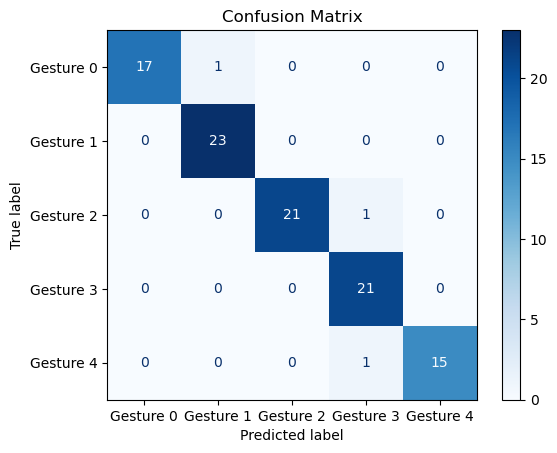

In [24]:
#display confusion matrix
labels = ['Gesture 0', 'Gesture 1', 'Gesture 2', 'Gesture 3', 'Gesture 4']

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
